In [1]:
import numpy as np
import sys
from pathlib import Path

# Add the parent directory of the notebook to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from utils.metrics import create_kl_adjacency
from utils.internal_validation_metrics import manual_silhouette_score, manual_dbi, manual_modularity

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
from IPython.display import display
# Read Parquet with PyArrow, keeping pandas metadata
table = pq.read_table("../data/sequence_dataset.parquet", use_pandas_metadata=True)
df = table.to_pandas()
display(df.head(5))

# Robust CTM stacking that unwraps singleton nesting and coerces to float array
def stack_ctm(entry):
    import ast

    e = entry
    # unwrap extra singleton nesting like [[...]] -> [...]
    while isinstance(e, (list, tuple)) and len(e) == 1:
        e = e[0]

    # if stored as a string, try to parse it
    if isinstance(e, str):
        e = ast.literal_eval(e)

    arr = np.array(e, dtype=object)

    # if object dtype, try to build numeric rows
    if arr.dtype == object:
        try:
            rows = [np.asarray(r, dtype=float) for r in arr]
            arr = np.vstack(rows)
        except Exception as exc:
            raise ValueError(f"Cannot convert CTM entry to numeric array: {exc}")

    # handle an extra leading singleton dimension (1,129,129)
    if arr.ndim == 3 and arr.shape[0] == 1 and arr.shape[1:] == (129, 129):
        arr = arr.squeeze(0)

    if arr.shape != (129, 129):
        raise ValueError(f"Unexpected CTM shape {arr.shape}; expected (129,129)")

    return arr.astype(float)

def normalize_global(M: np.ndarray) -> np.ndarray:
    total = M.sum()
    return M / total if total != 0 else M.astype(float)

# Apply conversion + normalization with index-aware errors for easier debugging
ctm_matrices = []
for i, e in enumerate(df["ctm"]):
    try:
        mat = stack_ctm(e)
        mat = normalize_global(mat)
        ctm_matrices.append(mat)
    except Exception as exc:
        raise ValueError(f"Error processing ctm at row {i}: {exc}")

df["ctm_matrix"] = ctm_matrices

# Quick verification
print("Rows:", len(df))
print("Example shape (row 0):", df.loc[0, "ctm_matrix"].shape)
print("Sum of example (row 0):", df.loc[0, "ctm_matrix"].sum())
# Optionally check that every matrix sums to 1 (or 0 if originally all zeros)
sums = df["ctm_matrix"].apply(np.sum)
print("Number of matrices with sum == 1:", (np.isclose(sums, 1.0)).sum())
print("Number of zero-sum matrices:", (sums == 0).sum())

In [ ]:
p = Path("../data") / "ctms_distance_matrix.npy"

if p.exists():
    print("Distance matrix already exists; loading from file.")
    distance_matrix = np.load(p)
else:
    ctms_list = df['ctm_matrix'].tolist()
    distance_matrix = create_kl_adjacency(ctms_list)
    np.save(p, distance_matrix)

Computing KL adjacency (unmasked): 100%|██████████| 3320/3320 [39:43<00:00,  1.39it/s]  


### Exploring the data

In [ ]:
def top_similar_songs_list(distance_matrix: np.ndarray, matrices_df=None, df: pd.DataFrame = None, top_k: int = 10):
    """
    Print all song pairs with distance == 0 and the top_k most similar pairs with distance > 0.
    Returns (zero_list, top_positive_list) where each list contains tuples:
      (song1_idx, song2_idx, song1_name, song2_name, distance)
    """
    # Build fallback matrices_df from df if not provided
    if matrices_df is None:
        if df is None:
            raise ValueError("Either 'matrices_df' or 'df' must be provided.")
        if 'ctm' in df.columns:
            matrices_df = df[['ctm']].copy()
        elif 'ctm_matrix' in df.columns:
            matrices_df = df[['ctm_matrix']].rename(columns={'ctm_matrix': 'ctm'}).copy()
        else:
            raise ValueError("Cannot build 'matrices_df': neither 'ctm' nor 'ctm_matrix' found in df.")
        matrices_df.index.name = 'song_idx'

    # Validate sizes
    n = distance_matrix.shape[0]
    if len(matrices_df) != n:
        raise ValueError(f"Length mismatch: distance_matrix is {n}x{n} but matrices_df has {len(matrices_df)} rows.")

    triu_idx = np.triu_indices(n, k=1)  # upper triangle indices
    all_pairs = [(i, j, float(distance_matrix[i, j])) for i, j in zip(*triu_idx)]

    # split zero and positive distances (use isclose for robust zero check)
    zero_pairs = [p for p in all_pairs if p[2] < 0.1]
    pos_pairs  = [p for p in all_pairs if p[2] >= 0.1]


    # sort positives by distance ascending (most similar first)
    pos_pairs.sort(key=lambda x: x[2])
    top_pos = pos_pairs[:top_k]

    # metadata source for names (fall back gracefully)
    meta_df = df if df is not None else matrices_df

    def _name_for(idx):
        if "name" in meta_df.columns:
            return meta_df.loc[idx, "name"]
        # try other common title-like fields
        for c in ("title", "song", "track"):
            if c in meta_df.columns:
                return meta_df.loc[idx, c]
        return str(idx)

    def _format(pairs):
        out = []
        for i, j, dist in pairs:
            s1 = matrices_df.index[i]
            s2 = matrices_df.index[j]
            n1 = _name_for(s1)
            n2 = _name_for(s2)
            out.append((s1, s2, n1, n2, dist))
        return out

    zero_formatted = _format(zero_pairs)
    top_positive_formatted = _format(top_pos)

    # Print results
    print(f"Found {len(zero_formatted)} zero-distance pairs (distance ~ 0).")
    for s1, s2, n1, n2, d in zero_formatted:
        print(f"{n1} ({s1}) <-> {n2} ({s2}): distance={d:.6f}")

    print(f"\nTop {len(top_positive_formatted)} most similar pairs with distance > 0:")
    for s1, s2, n1, n2, d in top_positive_formatted:
        print(f"{n1} ({s1}) <-> {n2} ({s2}): distance={d:.6f}")

    return zero_formatted, top_positive_formatted


# Usage example: print all zero-distance pairs and top 10 positives
zero_pairs, top_10_pos = top_similar_songs_list(distance_matrix, matrices_df=None, df=df, top_k=10)

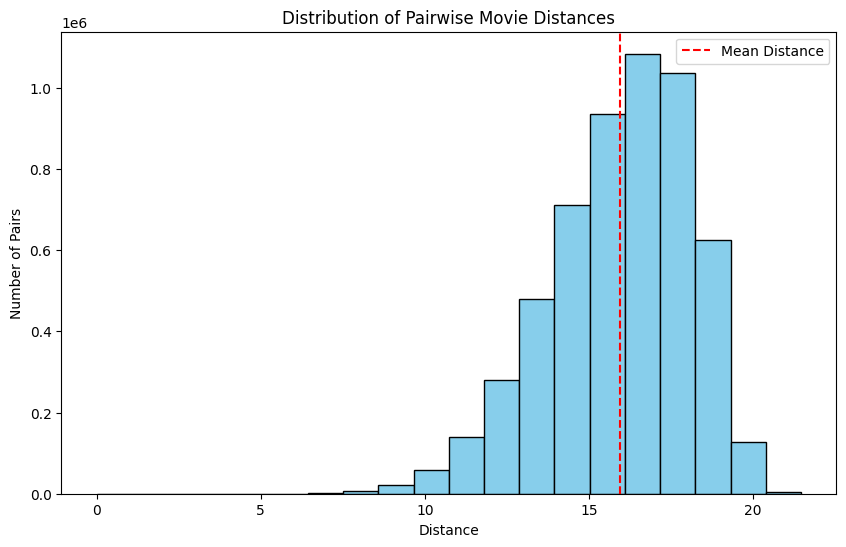

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get upper triangle indices, excluding the diagonal
triu_idx = np.triu_indices(distance_matrix.shape[0], k=1)
all_distances = distance_matrix[triu_idx]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_distances, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Pairwise Movie Distances")
plt.xlabel("Distance")
plt.ylabel("Number of Pairs")
plt.axvline(np.mean(all_distances), color='red', linestyle='dashed', label='Mean Distance')
plt.legend()
plt.show()

Top 2 most similar (excluding distance == 0 and identical-song pairs):


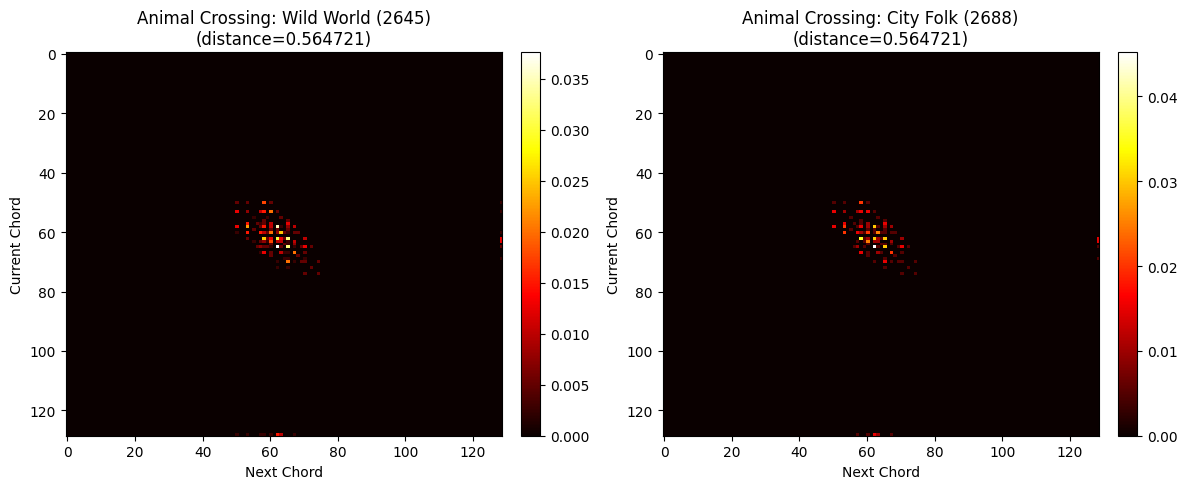

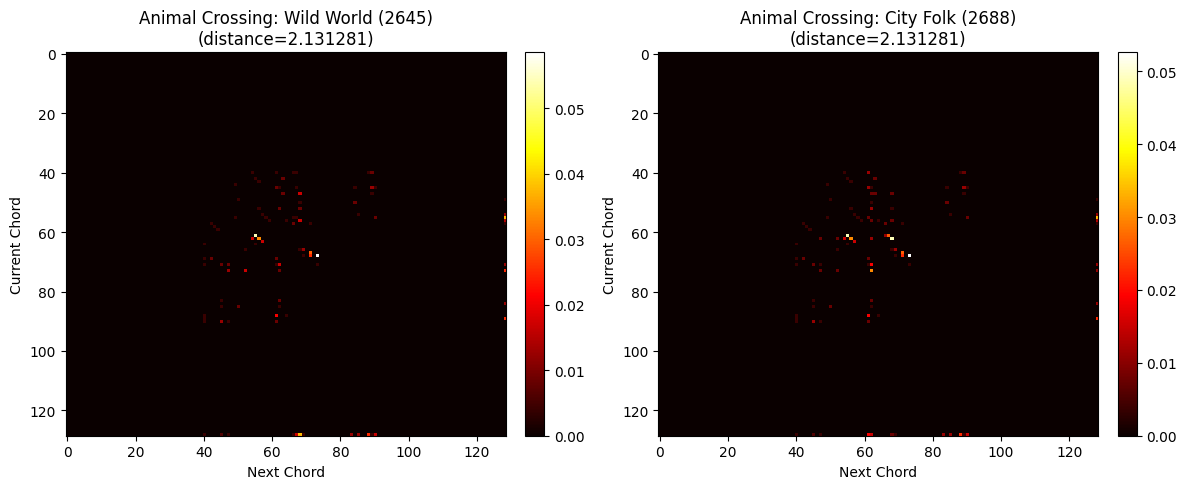


Top 2 most distant (distinct songs):


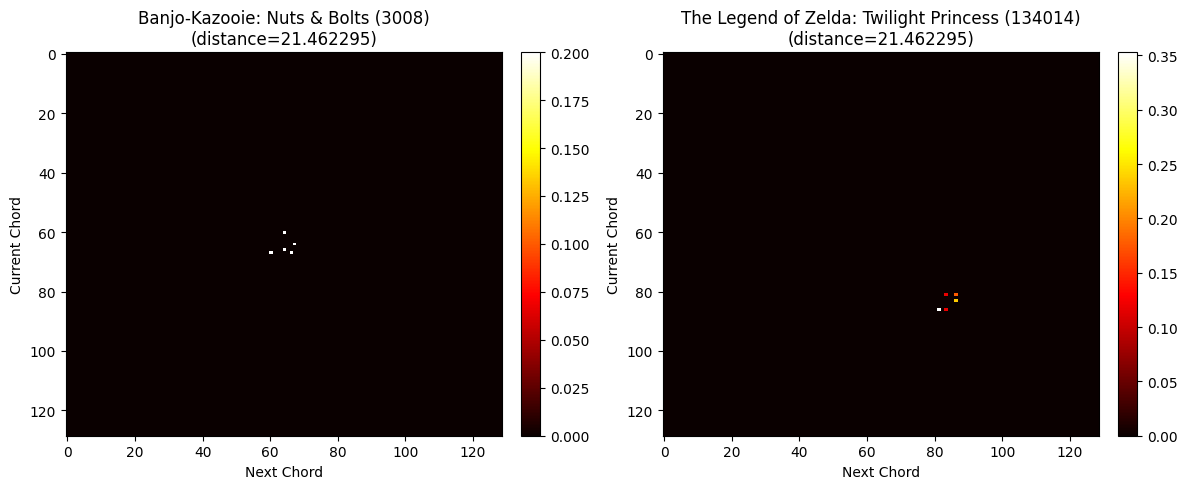

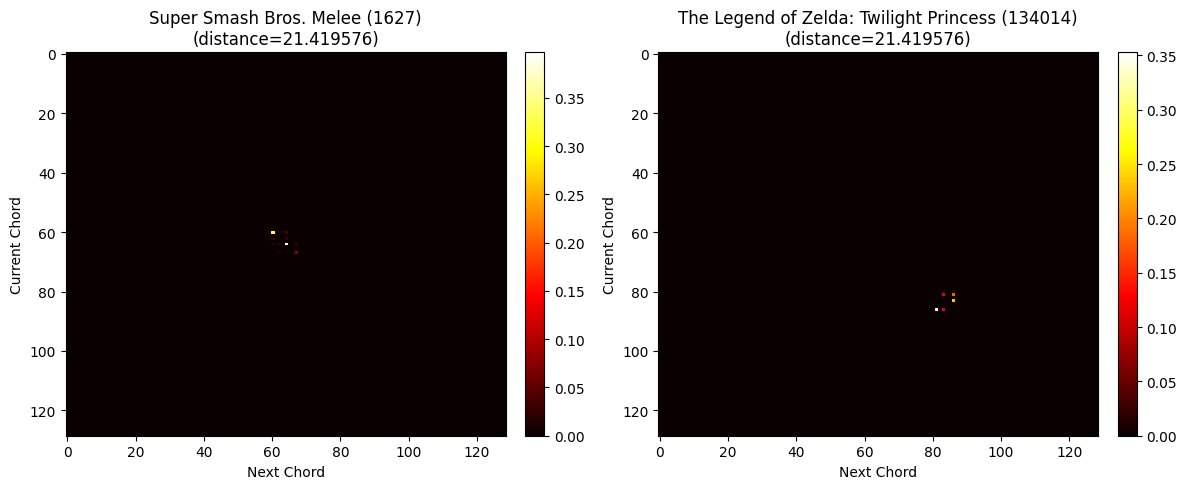

In [ ]:
if 'matrices_df' not in globals():
    if 'ctm_matrix' in df.columns:
        matrices_df = df[['ctm_matrix']].rename(columns={'ctm_matrix': 'ctm'}).copy()
    elif 'ctm' in df.columns:
        matrices_df = df[['ctm']].copy()
    else:
        raise ValueError("Cannot build matrices_df: neither 'ctm_matrix' nor 'ctm' found in df.")
    matrices_df.index.name = 'song_idx'

def get_top_pairs(distance_matrix, matrices_df=None, df=None, top_k=2, most_similar=True, exclude_zeros=False, distinct_songs=True):
    """
    Return top_k most similar/dissimilar song pairs.
    Returns tuples: (idx1, idx2, 'Song1 (Game1)', 'Song2 (Game2)', distance)

    Args:
        distance_matrix: np.ndarray, pairwise distances
        matrices_df: DataFrame with 'ctm' column (optional; will try to use global matrices_df)
        df: Original DataFrame with 'name' and preferably 'videogame'/'game'/'id' columns
        top_k: int
        most_similar: bool
        exclude_zeros: bool, if True exclude pairs with distance == 0 (useful for most_similar)
        distinct_songs: bool, if True exclude pairs that are actually the same song entry
                        (determined by 'id' if present, otherwise by name+game)
    """
    if matrices_df is None:
        if 'matrices_df' in globals():
            matrices_df = globals()['matrices_df']
        else:
            raise ValueError("matrices_df must be provided or exist in globals().")
    if df is None:
        if 'df' in globals():
            df = globals()['df']
        else:
            raise ValueError("df must be provided or exist in globals().")

    # helper to get display name and game
    def _get_game_name(idx):
        if "videogame" in df.columns:
            return df.loc[idx, "videogame"]
        if "game" in df.columns:
            return df.loc[idx, "game"]
        if "id" in df.columns:
            return df.loc[idx, "id"]
        return ""

    def _get_song_name(idx):
        if "name" in df.columns:
            return df.loc[idx, "name"]
        return str(idx)

    # helper to form an identity for equality check
    def _get_identity(idx):
        # prefer a dedicated id column if available
        if "id" in df.columns:
            return ("id", str(df.loc[idx, "id"]))
        # otherwise use (name, game) tuple
        name = _get_song_name(idx)
        game = _get_game_name(idx)
        return ("name_game", str(name), str(game))

    n = distance_matrix.shape[0]
    triu_idx = np.triu_indices(n, k=1)

    pairs = []
    # iterate and optionally filter identical-song pairs early to avoid including them
    for i, j in zip(*triu_idx):
        dist = float(distance_matrix[i, j])
        if exclude_zeros and dist == 0.0:
            continue

        if distinct_songs:
            idx1 = matrices_df.index[i]
            idx2 = matrices_df.index[j]
            if _get_identity(idx1) == _get_identity(idx2):
                # skip pairs that are actually the same song entry
                continue

        pairs.append((i, j, dist))

    pairs.sort(key=lambda x: x[2], reverse=not most_similar)
    top_pairs = pairs[:top_k]

    formatted = []
    for i, j, dist in top_pairs:
        idx1 = matrices_df.index[i]
        idx2 = matrices_df.index[j]

        song1_name = _get_song_name(idx1)
        song2_name = _get_song_name(idx2)

        game1_name = _get_game_name(idx1)
        game2_name = _get_game_name(idx2)

        formatted.append((idx1, idx2, f"{song1_name} ({game1_name})", f"{song2_name} ({game2_name})", dist))
    return formatted

def plot_ctms_side_by_side(matrices_df=None, top_pairs=None):
    """
    Plot CTMs side by side for the provided pairs.

    Args:
        matrices_df: DataFrame with 'ctm' column (optional; will use global matrices_df)
        top_pairs: list of tuples returned by get_top_pairs:
            [(idx1, idx2, song1_str, song2_str, distance), ...]
    """
    if matrices_df is None:
        if 'matrices_df' in globals():
            matrices_df = globals()['matrices_df']
        else:
            raise ValueError("matrices_df must be provided or exist in globals().")
    if top_pairs is None or len(top_pairs) == 0:
        print("No pairs to plot.")
        return

    def _to_ndarray(ctm, idx_label=None):
        """
        Robustly convert a possibly nested/list CTM entry to a 2D float numpy array.
        Handles extra single-element nesting like [[matrix]] or [[[matrix]]], numpy arrays,
        and squeezes a leading singleton dimension (e.g., shape (1, H, W)).
        """
        # if already numpy array
        if isinstance(ctm, np.ndarray):
            arr = ctm.astype(float)
            if arr.ndim == 3 and arr.shape[0] == 1:
                arr = arr.squeeze(0)
            if arr.ndim != 2:
                raise ValueError(f"CTM at {idx_label} has ndim={arr.ndim}, expected 2.")
            return arr

        # unwrap repeated single-element nesting where inner element is list/array
        m = ctm
        while isinstance(m, (list, tuple)) and len(m) == 1 and isinstance(m[0], (list, tuple, np.ndarray)):
            m = m[0]

        try:
            arr = np.array(m, dtype=float)
        except Exception as e:
            raise ValueError(f"cannot convert CTM at {idx_label} to float array: {e}")

        # if shape like (1, H, W), squeeze that leading dimension
        if arr.ndim == 3 and arr.shape[0] == 1:
            arr = arr.squeeze(0)

        if arr.ndim != 2:
            raise ValueError(f"CTM at {idx_label} has ndim={arr.ndim}, expected 2.")

        return arr

    for entry in top_pairs:
        idx1, idx2, song1_str, song2_str, dist = entry

        raw1 = matrices_df.loc[idx1, 'ctm']
        raw2 = matrices_df.loc[idx2, 'ctm']

        try:
            M1 = _to_ndarray(raw1, idx_label=idx1)
        except ValueError as e:
            print(f"Skipping pair {idx1}-{idx2}: {e}")
            continue

        try:
            M2 = _to_ndarray(raw2, idx_label=idx2)
        except ValueError as e:
            print(f"Skipping pair {idx1}-{idx2}: {e}")
            continue

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        '''for ax, M, title in zip(axes, [M1, M2], [song1_str, song2_str]):
            im = ax.imshow(M, cmap='hot', aspect='auto', interpolation='nearest')
            ax.set_title(f"{title}\n(distance={dist:.3f})")
            ax.set_xlabel("Next Chord")
            ax.set_ylabel("Current Chord")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)'''

        # derive song id and videogame name for titles
        song1_id = idx1
        song2_id = idx2
        videogame_name1 = ""
        videogame_name2 = ""
        if 'df' in globals():
            dff = globals()['df']
            if "videogame" in dff.columns:
                videogame_name1 = dff.loc[idx1, "videogame"]
                videogame_name2 = dff.loc[idx2, "videogame"]
            elif "game" in dff.columns:
                videogame_name1 = dff.loc[idx1, "game"]
                videogame_name2 = dff.loc[idx2, "game"]
            elif "id" in dff.columns:
                videogame_name1 = str(dff.loc[idx1, "id"])
                videogame_name2 = str(dff.loc[idx2, "id"])

        for ax, M, song_id, videogame_name in zip(
            axes,
            [M1, M2],
            [song1_id, song2_id],
            [videogame_name1, videogame_name2]):
            title = f"{song_id} from {videogame_name}" if videogame_name not in (None, "") else f"{song_id}"
            im = ax.imshow(M, cmap='hot', aspect='auto', interpolation='nearest')
            ax.set_title(f"{title}\n(distance={dist:.3f})")
            ax.set_xlabel("Next Chord")
            ax.set_ylabel("Current Chord")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

# Ensure distance_matrix is available (try to load from p if not)
if 'distance_matrix' not in globals():
    if 'p' in globals():
        distance_matrix = np.load(p)
    else:
        raise ValueError("distance_matrix not found in globals and no path 'p' provided to load it.")

# Top 2 most similar (exclude exact-zero distances) -- now will skip identical song entries
top_similar = get_top_pairs(distance_matrix, matrices_df=globals().get('matrices_df', None),
                            df=globals().get('df', None), top_k=2, most_similar=True, exclude_zeros=True, distinct_songs=True)

# Top 2 most distant (largest distances)
top_dissimilar = get_top_pairs(distance_matrix, matrices_df=globals().get('matrices_df', None),
                               df=globals().get('df', None), top_k=2, most_similar=False, exclude_zeros=False, distinct_songs=True)

print("Top 2 most similar (excluding identical-song pairs):")
plot_ctms_side_by_side(matrices_df=globals().get('matrices_df', None), top_pairs=top_similar)

print("\nTop 2 most distant:")
plot_ctms_side_by_side(matrices_df=globals().get('matrices_df', None), top_pairs=top_dissimilar)

## Spectral clustering

### Step 1: Distances to similarity

In [ ]:
def distance_to_similarity(D: np.ndarray, sigma: float = None) -> np.ndarray:
    """
    Convert distance matrix D to similarity matrix S using a Gaussian kernel.
    """
    # Heuristic for sigma: median of non-zero distances
    if sigma is None:
        sigma = np.median(distance_matrix[D > 0]) / 2  # or even /3
        print(f"Using sigma = {sigma:.4f}")
    
    S = np.exp(-D**2 / (2 * sigma**2))
    np.fill_diagonal(S, 0)  # no self-similarity links
    return S

sim_matrix = distance_to_similarity(distance_matrix)

Using sigma = 8.1123


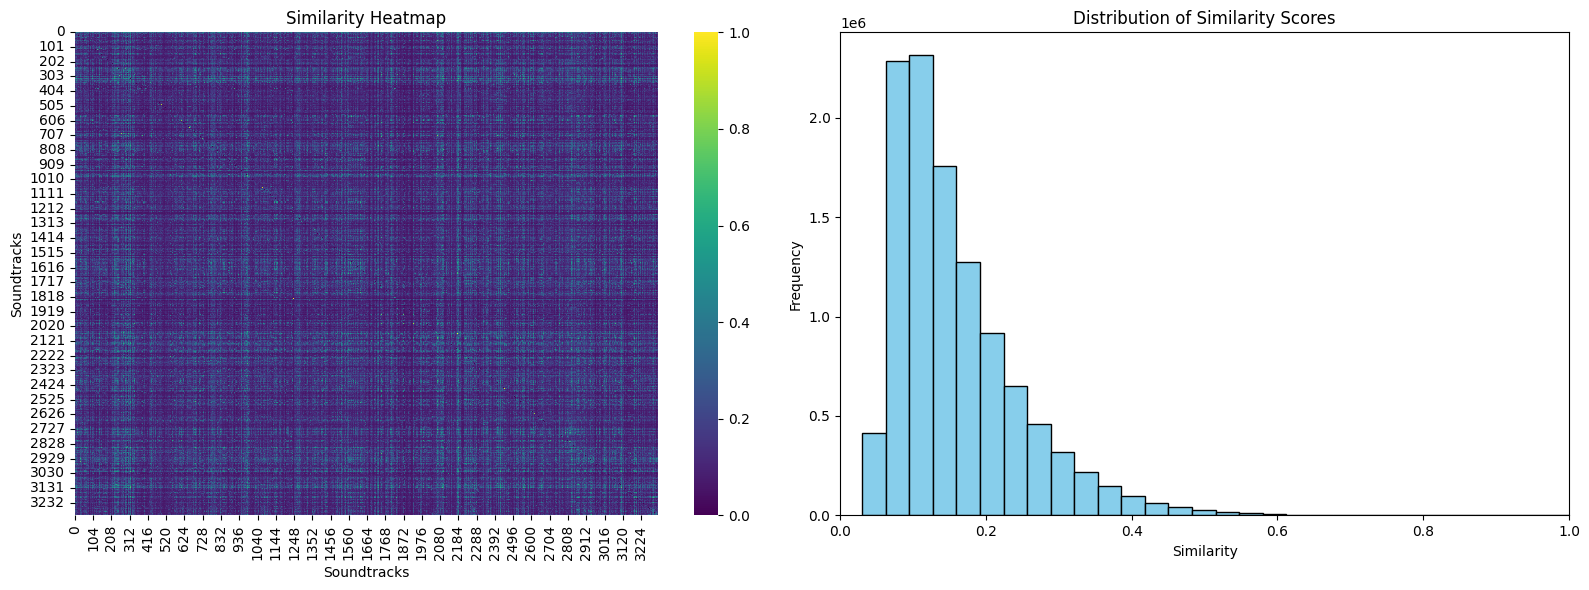

Mean similarity: 0.1587
Standard deviation: 0.0863


In [ ]:
import seaborn as sns

sim_values = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(sim_matrix, cmap="viridis", ax=axes[0])
axes[0].set_title("Similarity Heatmap")
axes[0].set_xlabel("Soundtracks")
axes[0].set_ylabel("Soundtracks")

# Histogram
axes[1].hist(sim_values.flatten(), bins=30, color='skyblue', edgecolor='black')
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

mean_sim = np.mean(sim_values)
std_sim = np.std(sim_values)

print(f"Mean similarity: {mean_sim:.4f}")
print(f"Standard deviation: {std_sim:.4f}")

### Step 2: Compute the Laplacian

In [ ]:
from scipy.linalg import fractional_matrix_power

D = np.diag(sim_matrix.sum(axis=1))
D_inv_sqrt = fractional_matrix_power(D, -0.5)
L_sym = np.eye(sim_matrix.shape[0]) - D_inv_sqrt @ sim_matrix @ D_inv_sqrt

### Step 3: Spectral Embedding + k-Means

In [ ]:
from scipy.linalg import eigh
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

k_values = range(2, 10)
scores = []
mod_scores = []
dbi_scores = []
labels_all = {}   # store labels for each k

for k in k_values:
    eigvals, eigvecs = eigh(L_sym)
    X = eigvecs[:, :k]
    X_norm = normalize(X, norm='l2', axis=1)

    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_norm)
    labels_all[k] = labels

    # silhouette
    sill = manual_silhouette_score(X_norm, labels)
    scores.append(sill)

    # Davies–Bouldin Index (lower is better)
    dbi = manual_dbi(X_norm, labels)
    dbi_scores.append(dbi)

    # modularity
    mod = manual_modularity(sim_matrix, labels)
    mod_scores.append(mod)

<Figure size 800x500 with 0 Axes>

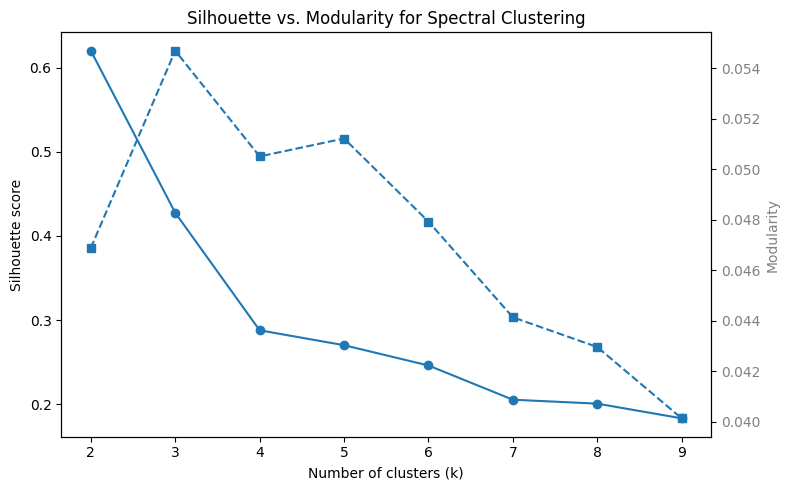

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))

# --- Silhouette (left axis) ---
ax1.set_xlabel("Number of clusters (k)")
ax1.set_ylabel("Silhouette score", color='black')
ax1.plot(k_values, scores, marker='o')
ax1.tick_params(axis='y', labelcolor='black')

# --- Davies–Bouldin Index (right axis) ---
ax2 = ax1.twinx()  # second y-axis sharing x
ax2.set_ylabel("Davies–Bouldin Index (lower is better)", color='gray')
ax2.plot(k_values, dbi_scores, marker='s', linestyle='--')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title("Silhouette vs. Davies–Bouldin Index for Spectral Clustering")
plt.tight_layout()
plt.show()

- Metrics measure different structures in different spaces:

  - **Silhouette Score**  
    Evaluates how well points cluster in the **feature space** using distances. A score around 0.5 indicates clusters are moderately well-separated.  
    **Applicable to:** Any clustering method that assigns each point to one cluster and provides a distance metric, e.g., k-means, k-medoids, hierarchical clustering, Gaussian Mixtures (via distance to means), spectral clustering.

  - **Modularity**  
    Evaluates how well communities align with **graph connectivity**. When using a Gaussian kernel on distances, similarities decay smoothly with distance; even well-separated clusters in feature space may produce fully connected, smoothly weighted graphs, giving modularity little contrast between “within-community” and “between-community” weights.  
    **Applicable to:** Methods producing or convertible into graph communities, e.g., graph-based clustering, community detection algorithms, or any clustering where a similarity/adjacency graph can be formed.

  - **Davies–Bouldin Index (DBI)** (lower is better)  
    Measures cluster **compactness relative to separation** in feature space.  
    **Applicable to:** Any clustering assigning points to clusters with a distance metric, e.g., k-means, k-medoids, hierarchical clustering, Gaussian Mixtures (via cluster means), spectral clustering.

### Step 4: Pick best $k$

In [ ]:
best_k = k_values[np.argmin(dbi_scores)]
best_labels = labels_all[best_k]
print("Best k by DBI:", best_k)

Best k by modularity: 3


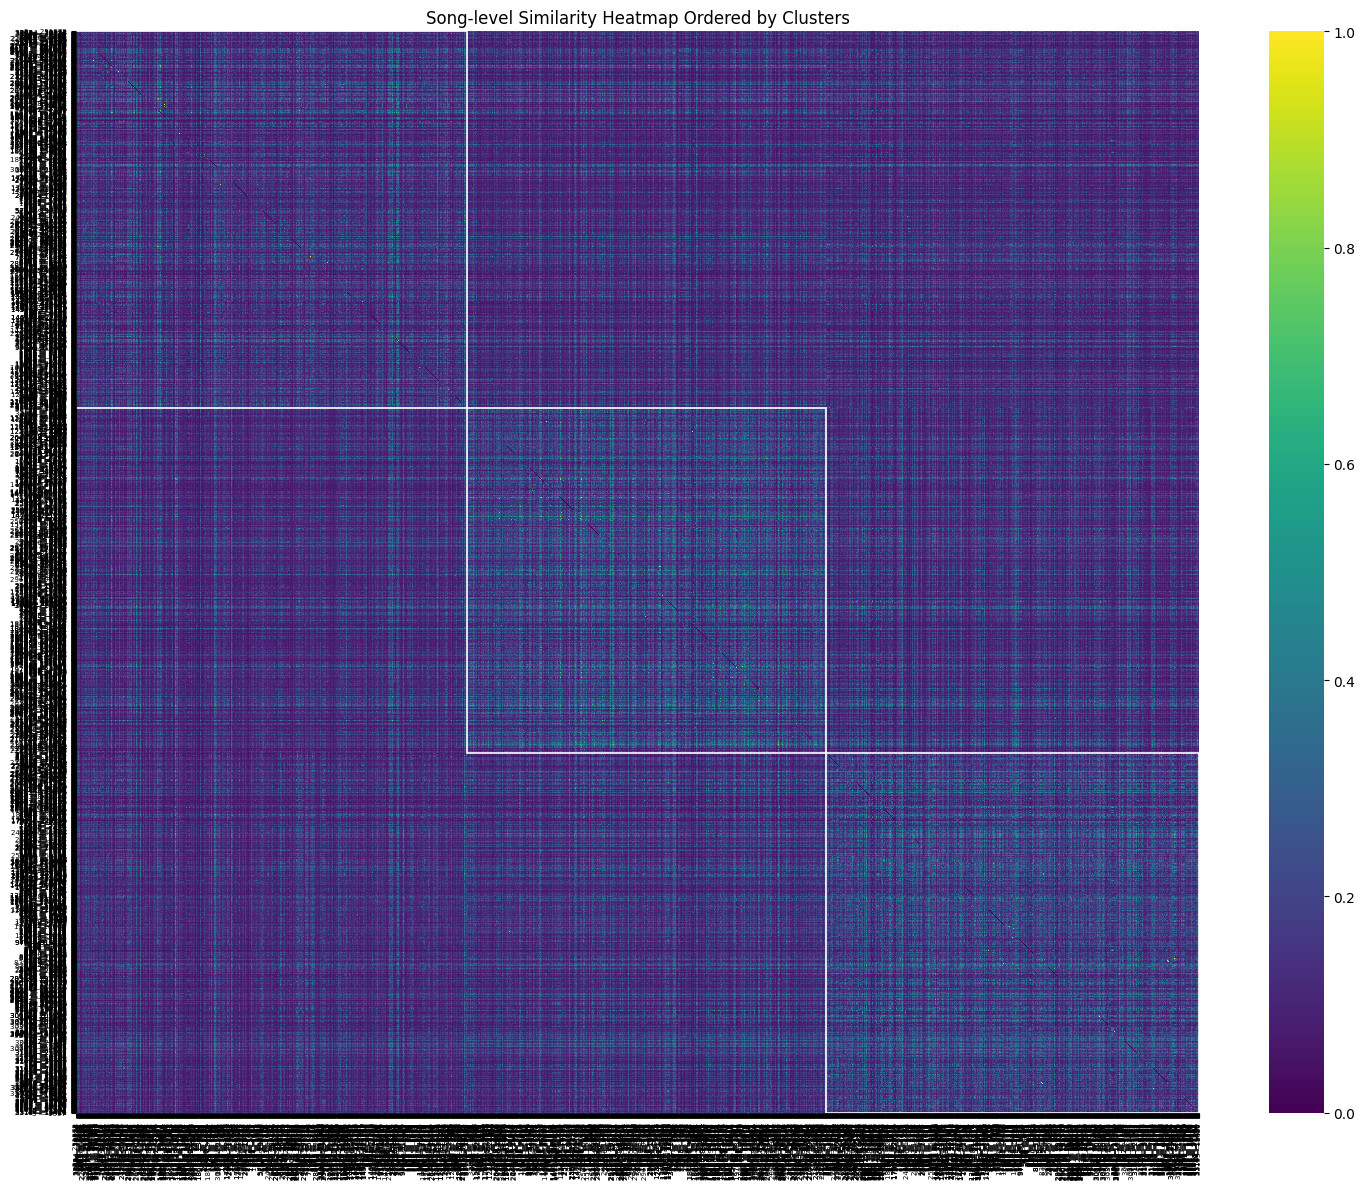

In [31]:
from matplotlib.patches import Rectangle

labels = best_labels  # use the spectral clustering result chosen earlier

# Order indices by cluster label
order = np.argsort(labels)
sim_ordered = sim_matrix[np.ix_(order, order)]

# Create axis labels: "<song_idx> — <game or fallback>" using the parquet df as metadata source
titles_ordered = []
for pos in order:
    idx = matrices_df.index[pos]
    # choose game-like column with fallbacks from df
    if "game" in df.columns:
        game_name = df.loc[idx, "game"]
    elif "videogame" in df.columns:
        game_name = df.loc[idx, "videogame"]
    elif "id" in df.columns:
        game_name = df.loc[idx, "id"]
    elif "name" in df.columns:
        game_name = df.loc[idx, "name"]
    else:
        game_name = ""
    titles_ordered.append(f"{idx} — {game_name}")

labels_ordered = labels[order]

# Identify cluster boundaries robustly
if len(labels_ordered) == 0:
    boundaries = [0]
else:
    change_pts = np.where(np.diff(labels_ordered) != 0)[0] + 1
    boundaries = [0] + change_pts.tolist() + [len(labels_ordered)]

# Plot heatmap ordered by cluster
plt.figure(figsize=(15, 12))
ax = sns.heatmap(
    sim_ordered,
    xticklabels=titles_ordered,
    yticklabels=titles_ordered,
    cmap="viridis"
)

plt.title("Song-level Similarity Heatmap Ordered by Clusters")
plt.xticks(rotation=90, fontsize=5)
plt.yticks(rotation=0, fontsize=5)

# Draw white boxes around clusters on the diagonal
for i in range(len(boundaries) - 1):
    start = boundaries[i]
    end = boundaries[i + 1]
    size = end - start
    rect = Rectangle((start, start), size, size, fill=False, edgecolor='white', linewidth=1.2)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()


In [33]:
# get cluster labels from available globals
if 'labels' in globals():
    labels_arr = labels
elif 'best_labels' in globals():
    labels_arr = best_labels
elif 'labels_all' in globals() and 'best_k' in globals():
    labels_arr = labels_all[best_k]
else:
    raise ValueError("No cluster labels found in globals() (expected 'labels' or 'best_labels').")

# attach cluster column to matrices_df if missing or out-of-date
if 'cluster' not in matrices_df.columns or len(matrices_df) != len(labels_arr) or not np.array_equal(matrices_df['cluster'].to_numpy(), labels_arr):
    matrices_df['cluster'] = labels_arr

# determine number of clusters
k = int(labels_arr.max() + 1)

# helper to pick a suitable metadata field from the parquet df
def _game_for(idx):
    for c in ('game', 'videogame', 'id', 'name'):
        if c in df.columns:
            return df.loc[idx, c]
    return ""

for cluster_id in range(k):
    print(f"\nCluster {cluster_id + 1}:")
    # indices (positions in the parquet / df) belonging to this cluster
    song_indices = matrices_df[matrices_df['cluster'] == cluster_id].index

    # Build labels: "<song_idx> (<videogame or fallback>)"
    cluster_labels = [f"{int(idx)} ({_game_for(idx)})" for idx in song_indices]
    print(cluster_labels)


Cluster 1:
['0 (4181)', '1 (4181)', '7 (251979)', '8 (251979)', '9 (251979)', '46 (1204)', '62 (1204)', '63 (1204)', '74 (1712)', '75 (1712)', '76 (1712)', '77 (1712)', '78 (4063)', '79 (4063)', '80 (2334)', '83 (2333)', '84 (970)', '87 (229177)', '90 (229177)', '91 (229177)', '94 (229177)', '95 (229177)', '96 (229177)', '97 (229177)', '102 (229177)', '106 (229177)', '107 (229177)', '108 (229177)', '110 (229177)', '115 (90109)', '116 (90109)', '128 (90109)', '131 (1323)', '138 (28445)', '142 (2344)', '143 (2344)', '144 (2344)', '148 (2344)', '154 (1700)', '155 (248530)', '156 (3492)', '159 (3492)', '162 (3492)', '171 (3492)', '178 (3492)', '179 (3492)', '180 (3492)', '184 (3403)', '185 (3403)', '186 (3403)', '188 (3403)', '189 (3403)', '197 (4105)', '201 (4105)', '207 (1441)', '209 (1627)', '212 (1627)', '213 (1627)', '219 (1627)', '226 (1627)', '227 (1627)', '228 (1627)', '235 (1627)', '236 (1627)', '244 (1627)', '245 (1627)', '247 (1627)', '252 (1627)', '261 (1627)', '263 (1627)', '

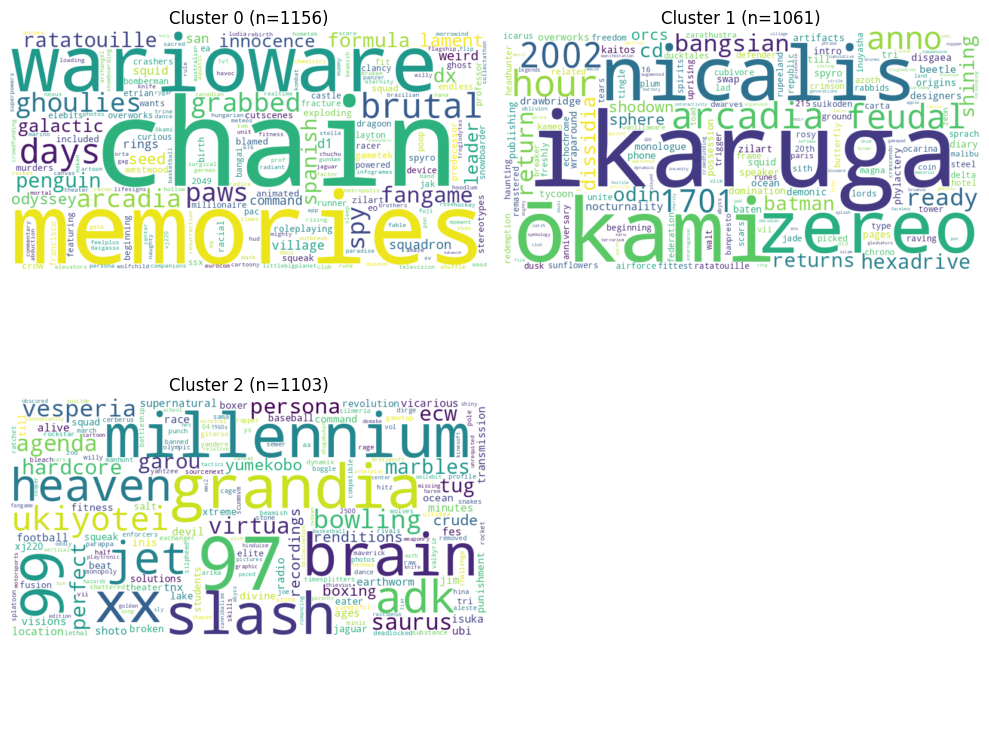

In [50]:
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Build metadata_df from parquet df and ensure cluster column is present
if 'matrices_df' in globals() and 'cluster' in matrices_df.columns:
    metadata_df = df.copy()
    # matrices_df.index are the song indices into df; align cluster by index
    metadata_df['cluster'] = matrices_df['cluster'].reindex(df.index).to_numpy()
else:
    raise ValueError("matrices_df with 'cluster' column is required in globals()")

# columns to merge
cols = ['name', 'keywords', 'themes', 'involved_companies']
cols = [c for c in cols if c in metadata_df.columns]
if not cols:
    raise ValueError("None of expected metadata columns found: keywords, themes, involved_companies")

def parse_list_field(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return []
    if isinstance(x, (list, tuple)):
        return [str(i) for i in x]
    if isinstance(x, str):
        s = x.strip()
        # try literal_eval for JSON-like lists
        try:
            val = ast.literal_eval(s)
            if isinstance(val, (list, tuple)):
                return [str(i) for i in val]
        except Exception:
            pass
        # fallback: remove brackets and split on commas
        s2 = s.strip("[]")
        parts = [p.strip().strip('"\'' ) for p in s2.split(",") if p.strip()]
        return parts
    return [str(x)]

# create combined text per song from the fields
def make_combined_text(row):
    toks = []
    for c in cols:
        toks.extend(parse_list_field(row.get(c, None)))
    # also include name if present for more context (optional)
    if 'name' in metadata_df.columns and pd.notna(row.get('name')):
        toks.append(str(row.get('name')))
    return " ".join([t.lower() for t in toks])

metadata_df['combined_text'] = metadata_df.apply(make_combined_text, axis=1)

# Fit TF-IDF on full corpus (only on combined fields)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
vectorizer.fit(metadata_df['combined_text'].fillna(''))

# Prepare cluster texts
cluster_ids = sorted(metadata_df['cluster'].dropna().unique().astype(int))
n_clusters = len(cluster_ids)
cluster_texts = [
    " ".join(metadata_df[metadata_df['cluster'] == cid]['combined_text'].fillna(''))
    for cid in cluster_ids
]

# Compute TF-IDF per-cluster (treating each cluster as one "document")
tfidf_mat = vectorizer.transform(cluster_texts)  # shape (n_clusters, n_features)
# Count in how many clusters each term appears (cluster document frequency)
presence = (tfidf_mat > 0).astype(int).sum(axis=0)     # sparse -> matrix
cluster_df = np.asarray(presence).ravel()            # array of length n_features

# Cluster-level IDF-like weight to penalize terms that appear across many clusters
# If a term appears in all clusters, weight -> log((n+1)/(n+1)) = 0 (fully penalized)
cluster_idf = np.log((n_clusters + 1.0) / (cluster_df + 1.0))

# Apply the cluster-level penalty to per-cluster TF-IDF scores
adjusted = tfidf_mat.toarray() * cluster_idf[np.newaxis, :]  # shape (n_clusters, n_features)

# Optionally, you can also subtract a small fraction of the global mean to further demote very common tokens:
# alpha = 0.0  # set to e.g. 0.5 to be more aggressive
# global_mean = adjusted.mean(axis=0)
# adjusted = np.maximum(0.0, adjusted - alpha * global_mean[np.newaxis, :])

words = vectorizer.get_feature_names_out()

# layout for plotting
n_cols = math.ceil(math.sqrt(n_clusters))
n_rows = math.ceil(n_clusters / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).flatten()

for i, cid in enumerate(cluster_ids):
    row_scores = adjusted[i]
    # build dict of positive scores only (penalized common terms will be near-zero)
    word_scores = {w: float(s) for w, s in zip(words, row_scores) if s > 0.0}
    if not word_scores:
        axes[i].axis('off')
        continue

    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(word_scores)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Cluster {cid} (n={len(metadata_df[metadata_df['cluster']==cid])})", fontsize=12)

# hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure first_release_year exists
if 'first_release_year' not in metadata_df.columns:
    raise ValueError("Column 'first_release_year' not found in metadata_df")

# Prepare layout
n_cols = math.ceil(math.sqrt(n_clusters))
n_rows = math.ceil(n_clusters / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.array(axes).flatten()

for i, cid in enumerate(cluster_ids):
    cluster_years = metadata_df.loc[metadata_df['cluster'] == cid, 'first_release_year'].dropna()
    
    if cluster_years.empty:
        axes[i].axis('off')
        continue

    mean_year = cluster_years.mean()
    std_year = cluster_years.std()
    
    axes[i].hist(cluster_years, bins=range(int(cluster_years.min()), int(cluster_years.max()) + 2), 
                 color='skyblue', edgecolor='black', alpha=0.7)
    
    axes[i].axvline(mean_year, color='red', linestyle='--', label=f"Mean={mean_year:.1f}")
    axes[i].axvline(mean_year + std_year, color='orange', linestyle=':', label=f"+1 SD={mean_year+std_year:.1f}")
    axes[i].axvline(mean_year - std_year, color='orange', linestyle=':', label=f"-1 SD={mean_year-std_year:.1f}")
    
    axes[i].set_title(f"Cluster {cid} (n={len(cluster_years)})", fontsize=12)
    axes[i].set_xlabel("First Release Year")
    axes[i].set_ylabel("Count")
    axes[i].legend(fontsize=8)

# hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()